In [1]:
import trimesh         # pip install trimesh
import citrix          # clone https://github.com/gagdiez/citrix
import nibabel as nib  # pip install nibabel
import numpy as np     # conda install numpy
import nimesh          # pip install numpy
import seaborn as sns  # conda install seaborn

from glob import glob
from collections import defaultdict

### MNI (ICBM152 asym 9c) Pial Surface

In [2]:
icbm_nimesh = nimesh.io.load(f'../../results/human-comparison/MNI-reconstructed-surfaces/lh.midthicknes.surf.gii')

### Human BA44

In [3]:
human44 = citrix.load(f'../../results/human-comparison/broca-ROIs/human.lh.BA44.func.gii').function_data

### Chimp BA44

In [4]:
chimp44 = citrix.load(f'../../results/human-comparison/broca-ROIs/chimp.lh.BA44.func.gii').function_data

### Clos

In [5]:
clos = []

for i in range(1,6):
    clos += [citrix.load(f'../../results/human-comparison/functional-ROIs/clos_2013_c{i}.func.gii').function_data > 0]

### Papitto Action Syntax

In [6]:
papitto = citrix.load(f'../../results/human-comparison/functional-ROIs/papitto_action.func.gii').function_data > 0

### Area Overlap

In [7]:
def area_of(mask, surface=icbm_nimesh):
    vertices = mask.nonzero()[0]
    triangles = [t for t in surface.triangles.tolist() if all([p in vertices for p in t])]
    submesh = trimesh.Trimesh(vertices=surface.vertices, faces=triangles)
    return submesh.area

In [8]:
def area_of_intersection(mask_A, mask_B, surface=icbm_nimesh):
    intersection = np.bitwise_and(mask_A, mask_B)
    return area_of(intersection, surface)

### Pappitto and Clos (K=5) vs Chimp BA44

Compute the overlap between functional regions and the (projected) left chimpanzee BA44 at different thresholds.

Please notice that only the chimpanze BA44 is being thresholded, and not the functional areas, since in all the cited studies the functional areas where used unthresholded.

In [9]:
papitto_overlap = []
closs_overlap = defaultdict(list)

for c_threshold in np.unique(chimp44)[:-2]:

    # Treshold Chimpanzee BA44
    print("Threshold:", c_threshold)
    chimp_44_thr = chimp44 > c_threshold
    chimp_area = area_of(chimp_44_thr)

    # Compute Area of Intersection between BA44_thr and Papitto
    intersection_area = area_of_intersection(chimp_44_thr, papitto)
    papitto_area = area_of(papitto)
    papitto_overlap.append(intersection_area / papitto_area)

    print(f"Overlap with Papitto:", intersection_area / papitto_area)

    for i in range(0, 5):
        intersection_area = area_of_intersection(chimp_44_thr, clos[i])
        closs_area = area_of(clos[i])

        closs_overlap[i].append(intersection_area / closs_area)

        print(f"Overlap with Clos-{i+1}: ", intersection_area / closs_area)

    print()

Threshold: 0.0
Overlap with Papitto: 0.3233562243478834
Overlap with Clos-1:  0.9574729171858508
Overlap with Clos-2:  0.4865757626984088
Overlap with Clos-3:  0.36396106382401694
Overlap with Clos-4:  0.6614353135990809
Overlap with Clos-5:  0.7869884811131547

Threshold: 0.11111111
Overlap with Papitto: 0.27030968181240933
Overlap with Clos-1:  0.4450783628384575
Overlap with Clos-2:  0.27933731256159094
Overlap with Clos-3:  0.2271234902564114
Overlap with Clos-4:  0.48788620037262687
Overlap with Clos-5:  0.49885111635989937

Threshold: 0.22222222
Overlap with Papitto: 0.230614310982103
Overlap with Clos-1:  0.3395531289941998
Overlap with Clos-2:  0.21795105475318124
Overlap with Clos-3:  0.12370314443600886
Overlap with Clos-4:  0.4182040621344449
Overlap with Clos-5:  0.3315497890435435

Threshold: 0.33333334
Overlap with Papitto: 0.18859234019708193
Overlap with Clos-1:  0.29106740541174925
Overlap with Clos-2:  0.10692607496186636
Overlap with Clos-3:  0.07574070182554632
Over

## Plot

In [10]:
from matplotlib import pyplot as plt

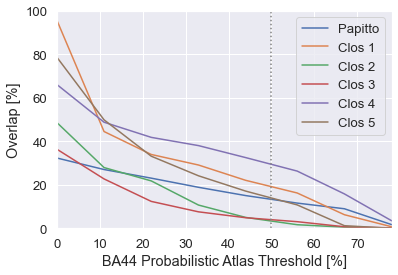

In [11]:
thresholds = (np.unique(chimp44)[:-2] * 100).round()

sns.set(font_scale=1.2)
sns.set_style("darkgrid")
sns.lineplot(x=thresholds, y=np.multiply(papitto_overlap, 100), label="Papitto")
sns.lineplot(x=thresholds, y=np.multiply(closs_overlap[0],100), label="Clos 1")
sns.lineplot(x=thresholds, y=np.multiply(closs_overlap[1],100), label="Clos 2")
sns.lineplot(x=thresholds, y=np.multiply(closs_overlap[2],100), label="Clos 3")
sns.lineplot(x=thresholds, y=np.multiply(closs_overlap[3],100), label="Clos 4")
sns.lineplot(x=thresholds, y=np.multiply(closs_overlap[4],100), label="Clos 5")


plt.xlabel("BA44 Probabilistic Atlas Threshold [%]")
plt.ylabel("Overlap [%]")
plt.ylim(0, 100)
plt.xlim(0, thresholds.max())

plt.vlines(50, 0, 100, linestyle='dotted', color="gray")

plt.savefig('./SFig.pdf')